In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset = np.load('train_dataset_5k_60.npz')
val_dataset = np.load('validation_dataset_5k_40.npz')
test_dataset = np.load('test_dataset.npz')

# =========== Loading Datasets ===============

x_train = train_dataset['x'].reshape(3000, 784).astype("float32") / 255
y_train = train_dataset['y'].astype("float32")
  
x_val = val_dataset['x'].reshape(2000, 784).astype("float32") / 255
y_val = val_dataset['y'].astype("float32")   
                    
x_test = test_dataset['x'].reshape(10010, 784).astype("float32") / 255
y_test = test_dataset['y'].astype("float32")                    


x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape 

((3000, 784), (3000,), (2000, 784), (2000,), (10010, 784), (10010,))

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(784,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10)    # didn't use softmax since it will be called when (logits=true) in below step
])
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
@tf.function
def loss(w1,w2,lamda1, lamda2,loss_fn,y_train,logits): # Lambda
    total_loss = loss_fn(y_train,logits)
    return total_loss + (tf.math.exp(lamda1)*tf.nn.l2_loss(w1)+tf.math.exp(lamda2)*tf.nn.l2_loss(w2))/(2*y_train.shape[0])

In [ ]:
wt_layer1_init = model.layers[1].get_weights()
wt_layer2_init = model.layers[2].get_weights()

train_df = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_df = train_df.shuffle(buffer_size = 1024).batch(64)

def fmin_loss(lamda1, lamda2, epochs= 50, l_rate= 0.4, momentum= 0.0399, nesterov = True):      # lamda, not exp(lamda), Works with both tf.Variable and tf.constant type lambda input, (or just scalar)
    tf.keras.backend.clear_session()
    optimizer = keras.optimizers.SGD(learning_rate=l_rate,momentum = momentum , nesterov =nesterov )
    total_loss0 = 1e20

    for epoch in range(epochs):
        for step,(x_train,y_train) in enumerate(train_df):
            with tf.GradientTape() as tape:
                logits = model(x_train, training=True)
                w1 = model.layers[1].weights[0]
                w2 = model.layers[2].weights[0]
                total_loss1 = loss(w1,w2,lamda1, lamda2,loss_fn,y_train,logits)
                
            vars_list = model.trainable_weights
            grads = tape.gradient(total_loss1, vars_list)      # for ref  - https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough 
            optimizer.apply_gradients(zip(grads,vars_list))

        total_loss0 = total_loss1

    wt_layer1 = model.layers[1].get_weights()
    wt_layer2 = model.layers[2].get_weights()
    model.layers[1].set_weights(wt_layer1_init)
    model.layers[2].set_weights(wt_layer2_init)

    return [total_loss1, wt_layer1, wt_layer2]

In [ ]:
def f_val(w1,b1,w2,b2,lamda1, lamda2, xtr, ytr): # lamda -> Variable
    layer1_weights = [w1,b1]
    layer2_weights = [w2,b2]
    model.layers[1].set_weights(layer1_weights)
    model.layers[2].set_weights(layer2_weights)
    logits = model(xtr)
    return loss(w1,w2,lamda1, lamda2,loss_fn,ytr,logits)

def f_grad(w1,b1,w2,b2,lamda1, lamda2, xtr, ytr): # lamda -> Variable
    with tf.GradientTape() as tape:
        total_loss = f_val(w1,b1,w2,b2,lamda1, lamda2, xtr, ytr)
    vars_list = model.trainable_weights
    vars_list.append(lamda1)
    vars_list.append(lamda2)
    grads = tape.gradient(total_loss, vars_list) 
    return grads

def F_val(w1,b1,w2,b2, xval, yval):     
    layer1_weights = [w1,b1]
    layer2_weights = [w2,b2]
    model.layers[1].set_weights(layer1_weights)
    model.layers[2].set_weights(layer2_weights)
    logits = model(xval)
    return loss_fn(yval,logits)

def F_grad(w1,b1,w2,b2, xval, yval):   # float32 arrays
    with tf.GradientTape() as tape:
        total_loss = F_val(w1,b1,w2,b2,xval,yval)
    vars_list = model.trainable_weights
    grads = tape.gradient(total_loss, vars_list) 
    return grads

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt

def krig_conversion( lamdas ):
    Lam = []
    for lamda in lamdas:
        lamda = lamda.numpy()
        if np.isscalar(lamda) == True:
            Lam.append( lamda)
        else:
            Lam.append( lamda[0] )
    return tf.Variable(Lam, dtype = 'float32')

# NOTE: Function for prediction at multi-dimensional lamda, not multiple lamdas
def GPR( Lamda_sample, Phi_sample, lamda1, lamda2 ): # ( arr([[],[],...]), arr([[],[],...]), arr([[],[],...])  )

    lamdas = [lamda1, lamda2]
    x = np.array([krig_conversion( lamdas)])
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gaussian_process.fit(Lamda_sample, Phi_sample)

    k2_l = gaussian_process.kernel_.get_params()['k2__length_scale']
    y_pred, sigma = gaussian_process.predict(x, return_std=True)
    y_pred_grad = 0.0*y_pred

    k_val = gaussian_process.kernel_( Lamda_sample , np.atleast_2d(x) , eval_gradient=False).ravel() 
    x_diff_over_l_sq = ([lam_val-x for lam_val in Lamda_sample]/np.power(k2_l,2))#.ravel()
    intermediate_result = [k*i for k,i in zip(k_val,x_diff_over_l_sq)]
    final_result = 0
    for alpha, int_res in zip(gaussian_process.alpha_, intermediate_result):
        final_result += alpha*int_res
    final_result *= gaussian_process._y_train_std
    
    return [y_pred, final_result]


In [ ]:
def Function_Grad( w1,b1,w2,b2,lamda1,lamda2, Lamda_sample, Phi_sample, R_val, Mu_val,
                  xtr, ytr, xval, yval ):

    Phi = GPR( Lamda_sample, Phi_sample,lamda1,lamda2)
    Phi_val, Phi_grad = Phi[0], Phi[1]
    
    p1 = F_grad( w1,b1,w2,b2, xval, yval ) 
    p2 = ( R_val* ( f_val(w1,b1,w2,b2,lamda1,lamda2,xtr,ytr) -  Phi_val) + Mu_val )

    # print("\n Lamda1,2 = ", lamda1, lamda2)

    f_gradient = f_grad(w1,b1,w2,b2,lamda1,lamda2,xtr,ytr)

    p3 = f_gradient[:-2] + [f_gradient[-2].numpy()-Phi_grad[0][0],f_gradient[-1].numpy()-Phi_grad[0][1]]
    p2tp3 = [p2*elt for elt in p3]
    gradients = [e1+e2 for e1,e2 in zip(p1,p2tp3[:-2])] + p2tp3[-2:]
    gradients = [(tf.clip_by_norm(grad, clip_norm = 2.0)) for grad in gradients]
    return gradients   # Output : w1, b1, w2, b2, lamda : floar32 arrays

In [ ]:
def AugLag_Function( w1,b1,w2,b2,lamda1, lamda2, Lamda_sample, Phi_sample, R_val, Mu_val, xtr, ytr, xval, yval ):
    PHI = GPR( Lamda_sample, Phi_sample, lamda1,lamda2 )
    f_phi = f_val(w1,b1,w2,b2,lamda1,lamda2,xtr,ytr) - PHI[0]
    final_val = F_val(w1,b1,w2,b2,xval,yval) + (R_val/2) * f_phi**2 + Mu_val * f_phi
    return final_val.numpy()[0]

In [ ]:
import numpy as np

def Gradient_Descent(  w1,b1,w2,b2,lamda1,lamda2,Lamda_sample, Phi_sample, R_val, Mu_val, momentum, learning_rate,
                     batch_size=64, n_iter=500, F_tolerance=1e-6, opt_tolerance = 1e-10, dtype="float32", random_state=None ):

    seed   = None if random_state is None else int(random_state)
    rng    = np.random.default_rng(seed=seed)
    
    n_obs_tr  = x_train.shape[0]
    n_obs_val = x_val.shape[0]
    xy_train  = np.c_[x_train.reshape(n_obs_tr, -1), y_train.reshape(n_obs_tr, 1)]
    xy_val    = np.c_[x_val.reshape(n_obs_val, -1) , y_val.reshape(n_obs_val, 1) ]

    #print("\n Shapes tr,val = ", xy_train.shape, xy_val.shape)

    vector     = np.array( [w1, b1, w2, b2, lamda1, lamda2] )

    learn_rate = np.array(learning_rate, dtype=dtype)
    batch_size = int(batch_size)
    n_iter     = int(n_iter)
    fun_tolerance  = np.array(F_tolerance, dtype=dtype)
    diff_old       = np.array([0 for i in range(0,6)])  # difference_initial

    Z_val0, grad_old, loss_ = 1e20, 1e10, 1e20

    Z_val_track = []

    for _ in range(n_iter):
        
        rng.shuffle(xy_train)
        rng.shuffle(xy_val)

        idx_tr = np.random.randint( n_obs_tr, size=batch_size )
        idx_val = np.random.randint( n_obs_val, size=batch_size )
        #print(idx_tr,"\n\n",idx_val)
        x_batch_tr, y_batch_tr = xy_train[idx_tr, :-1], xy_train[idx_tr, -1:]
        x_batch_val, y_batch_val = xy_val[idx_val, :-1], xy_val[idx_val, -1:]

        Z_grad = Function_Grad( w1,b1,w2,b2,lamda1,lamda2, Lamda_sample, Phi_sample, R_val, Mu_val, x_batch_tr, y_batch_tr, x_batch_val, y_batch_val )
        Z_grad = np.array(Z_grad)
        diff_new = learning_rate*Z_grad

        [w1,b1,w2,b2,lamda1,lamda2] = np.array([w1,b1,w2,b2,lamda1,lamda2]) - ( learning_rate*diff_new + momentum*diff_old )
        diff_old = diff_new
        lamda1 = tf.Variable(lamda1, dtype = dtype)
        lamda2 = tf.Variable(lamda2, dtype = dtype)

        # ============= Termination Criterias Check ========================

        Z_val = AugLag_Function( w1,b1,w2,b2,lamda1, lamda2, Lamda_sample, Phi_sample, R_val, Mu_val, x_train, y_train, x_val, y_val )

        F_tol = abs(Z_val-Z_val0)/(1+abs(Z_val0))
        grad_tol = np.array( [np.linalg.norm(g, ord = np.inf) for g in Z_grad ] )
        Z_val0 = Z_val

        Z_val_track.append(Z_val)

        if np.all(grad_tol) <= opt_tolerance and F_tol <= F_tolerance:
            opt_weights = [w1,b1,w2,b2,lamda1,lamda2]
            loss_ = Z_val
            break
        elif Z_val <= loss_ :
            loss_ = Z_val
            opt_weights = [w1,b1,w2,b2,lamda1,lamda2]

    plt.plot(np.array(Z_val_track), linestyle = 'dotted')
    plt.show()

    return opt_weights, loss_

In [ ]:
# GLOBAL : Lamda_sample, Phi_sample
def Augmented_Lagrangian( w1, b1, w2, b2, lamda1, lamda2, Lamda_sample, Phi_sample, mom, lr, R_val = 2, Mu_val = 2, neta = 1.5, al_epochs = 5 ):
    Z_val0 = 1e+20
    Lamda_sampleL, Phi_sampleL = Lamda_sample, Phi_sample
    wts_opt0, lamda_opt10, lamda_opt20, min_violation = [], 0, 0, 10
    for epoch in range(al_epochs):

        Opt_Weights, _ = Gradient_Descent( w1,b1,w2,b2,lamda1, lamda2, Lamda_sampleL, Phi_sampleL, R_val, Mu_val, mom, lr )
        w1_opt,b1_opt,w2_opt,b2_opt, lamda_opt1, lamda_opt2 = Opt_Weights[0], Opt_Weights[1], Opt_Weights[2], Opt_Weights[3], Opt_Weights[4],Opt_Weights[5]  # lamda not var
        lamda_opt1 = tf.Variable(lamda_opt1, dtype=tf.float32)        
        lamda_opt2 = tf.Variable(lamda_opt2, dtype=tf.float32)

        # ========== NOT USED ====================
        #w1,b1,w2,b2,lamda1,lamda2 = w1_opt,b1_opt,w2_opt,b2_opt,lamda_opt1,lamda_opt2 
        Phi1 = GPR(Lamda_sampleL, Phi_sampleL, lamda1, lamda2)
        Phi_val1 = Phi1[0]

        # ==========UPDATING LAMBDA SAMPLE FOR GPR=========================
        
        Lamda_sampleL = np.array(np.vstack([Lamda_sampleL,[lamda_opt1.numpy()[0],lamda_opt2.numpy()[0]]]), dtype = 'float32')
        index = np.where(Lamda_sampleL == [lamda_opt1.numpy()[0],lamda_opt2.numpy()[0]] )
        Phi_new_lamda = fmin_loss(lamda_opt1,lamda_opt2)[0].numpy()
        Phi_sampleL = np.insert(Phi_sampleL, index[0][0], Phi_new_lamda)

        #print("\n Phi_new_lamda = ", Phi_new_lamda)

        # ============== Updating Augmented Lagrangian Parameters ====================
        constraint_ = f_val(w1_opt,b1_opt,w2_opt,b2_opt,lamda_opt1,lamda_opt2,x_train,y_train) - Phi_val1
        Mu_val = Mu_val + R_val*( constraint_ )
        R_val  = neta*R_val

        # ===== Constraint Violation Criteria ===================
        violation = abs(constraint_)
        print(f"\n {epoch} :: Violation = {violation}, Lambdas = {lamda_opt1.numpy(), lamda_opt2.numpy()}")
        if violation <= min_violation:
          wts_opt0 = [ [w1_opt, b1_opt], [w2_opt, b2_opt]]
          lamda_opt10, lamda_opt20 = lamda_opt1, lamda_opt2
          min_violation = violation
    
    print(f"\n\n AL Ended With Violation :: {min_violation}, Optimal Lambdas = {lamda_opt10, lamda_opt20}")
    return wts_opt0, lamda_opt10, lamda_opt20

In [ ]:
Lamda_sample1 = np.arange(-10,0,1.5, dtype = 'float32')

Lamda_sample = []
for x in Lamda_sample1:
    for y in Lamda_sample1:
            Lamda_sample.append( [x, y] )
Lamda_sample = np.array(Lamda_sample)

Phi_sample, Weights, lamda_init = [], [], 0
init_val_loss = 1e20

for lamda in Lamda_sample:
    
    [min_loss, layer1wt, layer2wt] = fmin_loss(lamda[0],lamda[1])
    Phi_sample.append( min_loss.numpy() )
    
    model.layers[1].set_weights(layer1wt)
    model.layers[2].set_weights(layer2wt)
    val_logits = model(x_val)
    val_loss = loss_fn(y_val,val_logits)
    if val_loss <= init_val_loss :
        init_val_loss = val_loss
        Weights = [layer1wt, layer2wt]
        lamda_init1 = lamda[0]
        lamda_init2 = lamda[1]

Phi_sample = np.array(Phi_sample)
print("\n\n Phi_sample: ", Phi_sample, "\n\n")

#============================== Initializing Weights =================================================
w1, b1 = Weights[0][0], Weights[0][1]
w2, b2 = Weights[1][0], Weights[1][1]
lamda1 = tf.Variable(lamda_init1, dtype = tf.float32)
lamda2 = tf.Variable(lamda_init2, dtype = tf.float32)




 Phi_sample:  [0.00295446 0.00106111 0.00133544 0.00332765 0.00981191 0.0241433
 0.04354591 0.00174418 0.00122685 0.00095472 0.00186742 0.0053791
 0.01314954 0.03358862 0.00325262 0.00291782 0.00288437 0.00350586
 0.00646516 0.01365723 0.03021779 0.01279154 0.01185187 0.01127751
 0.01123695 0.01387922 0.02133274 0.04040574 0.03716776 0.02912963
 0.02328646 0.02071757 0.02280406 0.0368339  0.07403232 0.04358584
 0.0266489  0.02088319 0.02150299 0.03465087 0.067565   0.12260569
 0.14762168 0.14922592 0.59925026 0.2751454  0.19571407 0.21416685
 0.20703566] 




In [ ]:
# LR : 0.20000000298023224, MOM : 0.08


 LR : 0.0010000000474974513, MOM : 0.1, Z_VAL : 0.08330963551998138


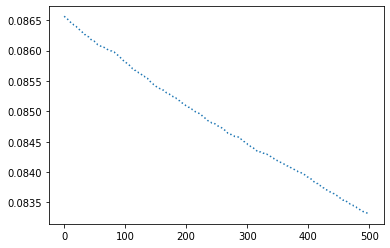


 LR : 0.0010000000474974513, MOM : 0.5, Z_VAL : 0.07436959445476532


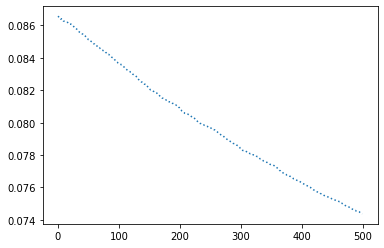


 LR : 0.0010000000474974513, MOM : 0.8, Z_VAL : 0.06922945380210876


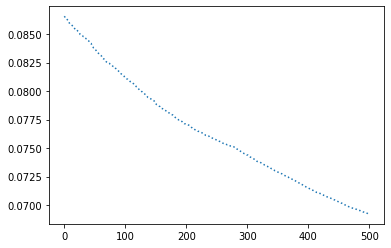


 LR : 0.0010000000474974513, MOM : 0.9, Z_VAL : 0.06792077422142029


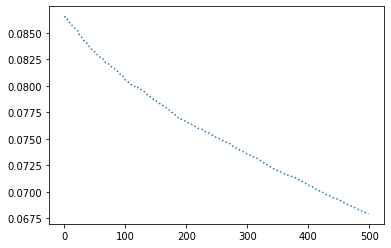


 LR : 0.0010000000474974513, MOM : 0.99, Z_VAL : 0.06652739644050598


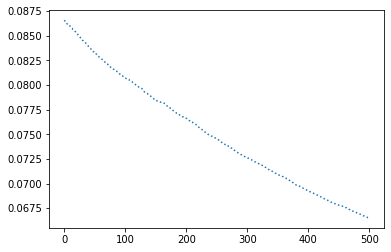


 LR : 0.009999999776482582, MOM : 0.1, Z_VAL : 0.06528285145759583


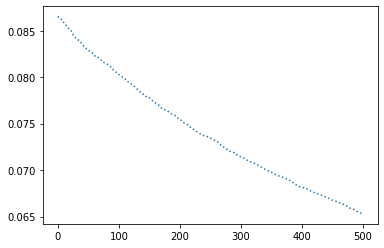


 LR : 0.009999999776482582, MOM : 0.5, Z_VAL : 0.022385358810424805


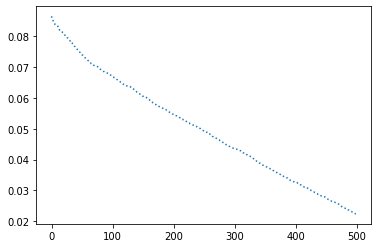


 LR : 0.009999999776482582, MOM : 0.8, Z_VAL : -0.005583122372627258


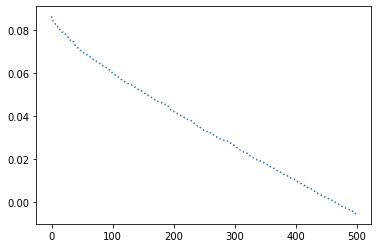


 LR : 0.009999999776482582, MOM : 0.9, Z_VAL : -0.013772785663604736


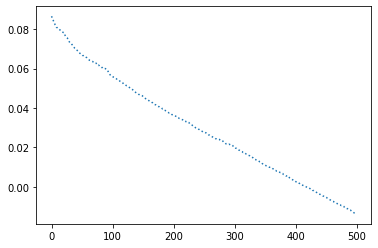


 LR : 0.009999999776482582, MOM : 0.99, Z_VAL : -0.021209925413131714


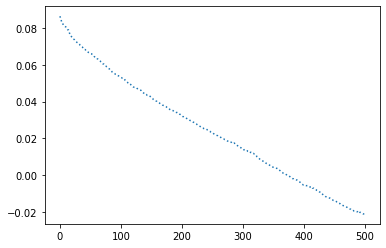


 LR : 0.05000000074505806, MOM : 0.1, Z_VAL : 0.00036735832691192627


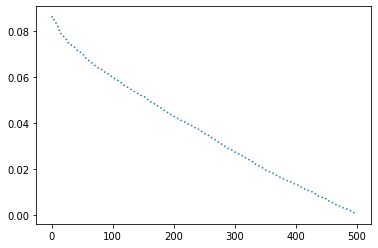


 LR : 0.05000000074505806, MOM : 0.5, Z_VAL : -0.1250688135623932


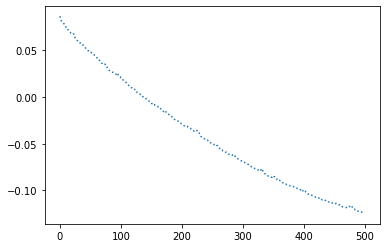


 LR : 0.05000000074505806, MOM : 0.8, Z_VAL : -0.16061639785766602


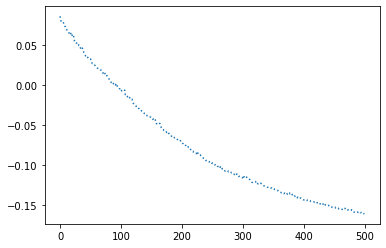


 LR : 0.05000000074505806, MOM : 0.9, Z_VAL : -0.16756395995616913


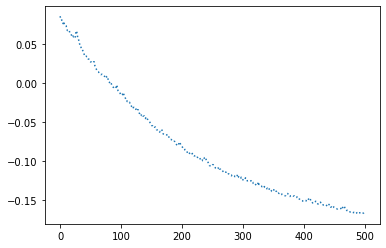


 LR : 0.05000000074505806, MOM : 0.99, Z_VAL : -0.17544931173324585


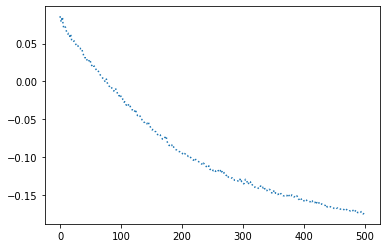


 LR : 0.07000000029802322, MOM : 0.1, Z_VAL : -0.03828534483909607


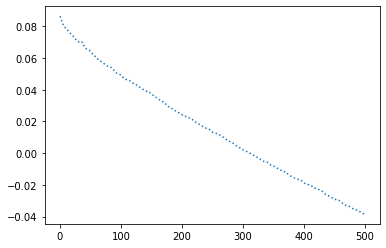


 LR : 0.07000000029802322, MOM : 0.5, Z_VAL : -0.1531560868024826


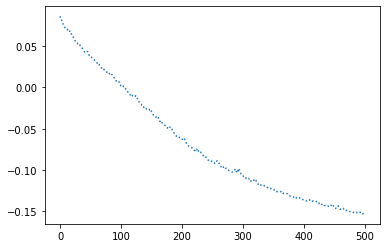


 LR : 0.07000000029802322, MOM : 0.8, Z_VAL : -0.185480535030365


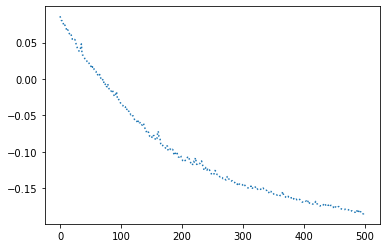


 LR : 0.07000000029802322, MOM : 0.9, Z_VAL : -0.194799542427063


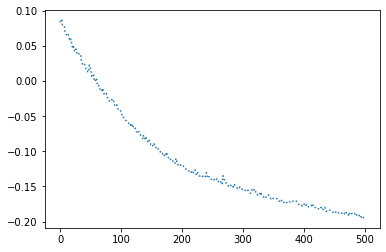


 LR : 0.07000000029802322, MOM : 0.99, Z_VAL : -0.1976650506258011


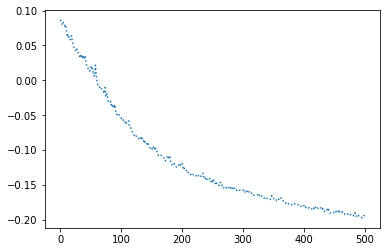


 LR : 0.10000000149011612, MOM : 0.1, Z_VAL : -0.09201103448867798


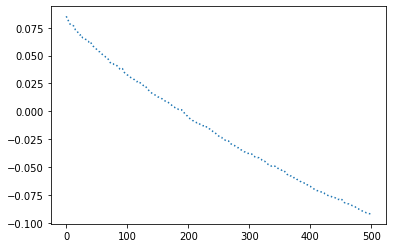


 LR : 0.10000000149011612, MOM : 0.5, Z_VAL : -0.18298029899597168


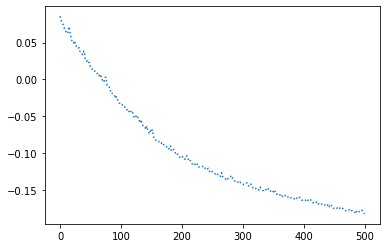


 LR : 0.10000000149011612, MOM : 0.8, Z_VAL : -0.21009978652000427


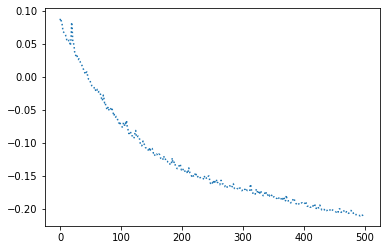


 LR : 0.10000000149011612, MOM : 0.9, Z_VAL : -0.21709764003753662


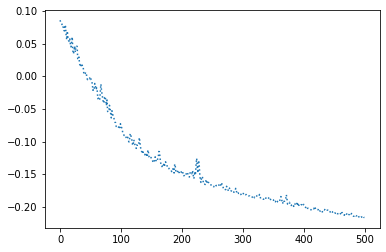


 LR : 0.10000000149011612, MOM : 0.99, Z_VAL : -0.22391223907470703


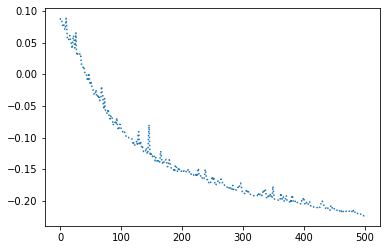



 Optimum :  -0.22391224  Momentum : 0.99, LR : 0.10000000149011612


In [ ]:
#learn_rate = np.arange( 0.1, 0.9, 0.1, dtype = 'float32' )
learn_rate = np.array( [0.001, 0.01, 0.05, 0.07, 0.1], dtype = 'float32' )
# momentum_set = np.arange( 0.01, 0.1, 0.01 )
momentum_set = np.array( [0.1, 0.5, 0.8, 0.9, 0.99] )
opt_val = 1e20
l0,m0 = 0,0
for lr in learn_rate:
    for mom in momentum_set:
        w1, b1 = Weights[0][0], Weights[0][1]
        w2, b2 = Weights[1][0], Weights[1][1]
        lamda1 = tf.Variable(lamda_init1, dtype = tf.float32)
        lamda2 = tf.Variable(lamda_init2, dtype = tf.float32)

        wt, val, y = Gradient_Descent( w1,b1,w2,b2,lamda1,lamda2,Lamda_sample, Phi_sample, R_val = 2, Mu_val = 2,  momentum = mom, learning_rate = lr )
        print("\n LR : {}, MOM : {}, Z_VAL : {}".format(lr,mom,val))
   
        
        if val <= opt_val:
            opt_val = val
            l0,m0 = lr,mom
print("\n\n Optimum : ",  opt_val, " Momentum : {}, LR : {}".format(m0,l0))

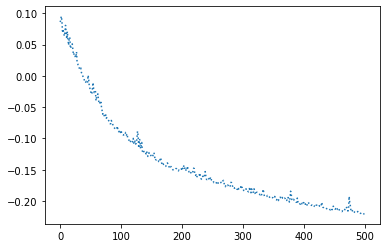


 0 :: Violation = [0.10662824], Lambdas = (array([-1.7171282], dtype=float32), array([-1.8444097], dtype=float32))


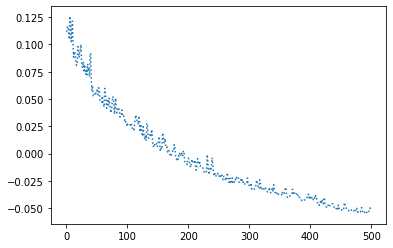


 1 :: Violation = [0.10692217], Lambdas = (array([-3.1931736], dtype=float32), array([-1.4181906], dtype=float32))


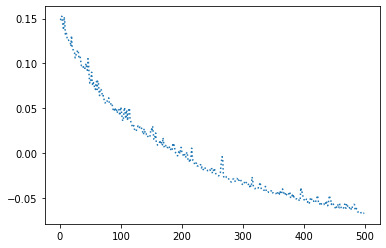


 2 :: Violation = [0.10427958], Lambdas = (array([-2.393599], dtype=float32), array([-0.94380087], dtype=float32))


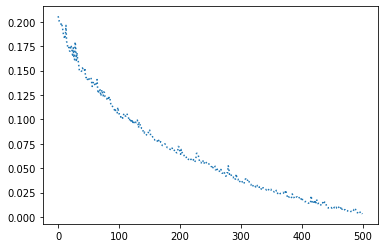


 3 :: Violation = [0.10003179], Lambdas = (array([-3.0878122], dtype=float32), array([-0.8831437], dtype=float32))


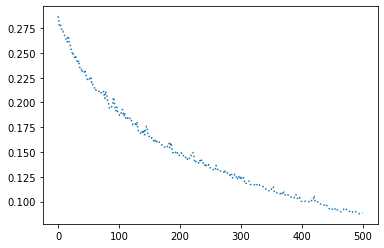


 4 :: Violation = [0.08770124], Lambdas = (array([-2.5904546], dtype=float32), array([-1.350508], dtype=float32))


 AL Ended With Violation :: [0.08770124], Optimal Lambdas = (<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-2.5904546], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-1.350508], dtype=float32)>)


 Optimal_Lambda =  -2.5904546 -1.350508 

RUN 0 :: Validation Loss : 0.07448487728834152, Training Loss : 0.03321653604507446, Testing Loss : 0.20347192883491516


In [ ]:
# ===========FINDING LOSS=======================
#w1_f,b1_f,w2_f,b2_f,lamda_f

for run in range(1):

    w1, b1 = Weights[0][0], Weights[0][1]
    w2, b2 = Weights[1][0], Weights[1][1]
    lamda1 = tf.Variable(lamda_init1, dtype = tf.float32)
    lamda2 = tf.Variable(lamda_init2, dtype = tf.float32)

    wt_final, lamda_final1, lamda_final2 = Augmented_Lagrangian( w1, b1, w2, b2, lamda1, lamda2, Lamda_sample, Phi_sample, m0, l0 )
    Final_weights_1, Final_weights_2 = wt_final[0], wt_final[1]

    model.layers[1].set_weights(Final_weights_1)
    model.layers[2].set_weights(Final_weights_2)

    val_logits = model(x_val)
    val_loss = loss_fn(y_val,val_logits)

    train_logits = model(x_train)
    training_loss = loss_fn(y_train,train_logits)

    test_logits = model(x_test)
    test_loss = loss_fn(y_test,test_logits)

    print("\n\n Optimal_Lambda = ", lamda_final1.numpy()[0],lamda_final2.numpy()[0], "\n")
    print(f'RUN {run} :: Validation Loss : {val_loss}, Training Loss : {training_loss}, Testing Loss : {test_loss}')